## Check Our Current Directory

In [1]:
import numpy as np 
import pandas as pd 

import os
print("Directory Path: " + os.getcwd())

Directory Path: /media/commlab/TenTB/home/jan/kaggle/fish-classification


## Get the dataset and all the classes
The class name is the same as the directory where the images are stored 

In [2]:
data_dir = """../../DATA/kaggle/Fish_Dataset/Fish_Dataset"""

classes = []

for directory in os.listdir(data_dir):
    if "." not in directory:           # Removes .txt and segmentation script
        classes.append(directory)
        
print(classes)

['Hourse Mackerel', 'Striped Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Gilt-Head Bream', 'Trout', 'Shrimp', 'Red Mullet', 'Black Sea Sprat']


### there are 9 classes : 
- Hourse Mackerel 
- Striped Red Mullet
- Red Sea Bream
- Sea Bass
- Gilt-Head Bream
- Trout
- Shrimp
- Red Mullet
- Black Sea Sprat

## Create full image path and class / label 
We will need this full path for pytorch dataset read the image 

In [3]:
image_paths = []
image_classes = np.array([[cls]*1000 for cls in classes]).reshape(-1) # create a classes array of shape (9000,)

for cls in classes:
    # adds the path of the image to the first column
    image_paths.extend(os.path.join(data_dir, cls, cls, i) for i in os.listdir(os.path.join(data_dir, cls, cls))) 

### put the list of the full path into data frame

In [4]:
data = pd.DataFrame({'path':image_paths, 'class':image_classes, })

print(data)

                                                   path            class
0     ../../DATA/kaggle/Fish_Dataset/Fish_Dataset/Ho...  Hourse Mackerel
1     ../../DATA/kaggle/Fish_Dataset/Fish_Dataset/Ho...  Hourse Mackerel
2     ../../DATA/kaggle/Fish_Dataset/Fish_Dataset/Ho...  Hourse Mackerel
3     ../../DATA/kaggle/Fish_Dataset/Fish_Dataset/Ho...  Hourse Mackerel
4     ../../DATA/kaggle/Fish_Dataset/Fish_Dataset/Ho...  Hourse Mackerel
...                                                 ...              ...
8995  ../../DATA/kaggle/Fish_Dataset/Fish_Dataset/Bl...  Black Sea Sprat
8996  ../../DATA/kaggle/Fish_Dataset/Fish_Dataset/Bl...  Black Sea Sprat
8997  ../../DATA/kaggle/Fish_Dataset/Fish_Dataset/Bl...  Black Sea Sprat
8998  ../../DATA/kaggle/Fish_Dataset/Fish_Dataset/Bl...  Black Sea Sprat
8999  ../../DATA/kaggle/Fish_Dataset/Fish_Dataset/Bl...  Black Sea Sprat

[9000 rows x 2 columns]


In [5]:
import PIL
import torch
import torchvision
import torchvision.transforms as transforms

## Prepare data pytorch data transform

In [6]:
# Those are the transformations we will apply in our dataset
transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))
    ])

In [7]:
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

## Encode the label

In [8]:
str_to_int = {
 'Hourse Mackerel': 0,
 'Black Sea Sprat': 1,
 'Sea Bass': 2,
 'Red Mullet': 3,
 'Trout': 4,
 'Striped Red Mullet': 5,
 'Shrimp': 6,
 'Gilt-Head Bream': 7,
 'Red Sea Bream': 8
}

## Create Pytorch Dataset

In [14]:
class MarketFishDataset(Dataset):
    def __init__(self, data, root_dir, transform=transforms.ToTensor()):
        self.data = data
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = self.data.iloc[idx, 0]
        image = Image.open(img_name)
        y_label = torch.tensor(str_to_int[self.data.iloc[idx, 1]])
        
        if self.transform:
            image = self.transform(image)
    
        return (image, y_label)

## create instance dataset

In [15]:
dataset = MarketFishDataset(
    data=data,
    root_dir=data_dir,
    transform=transform
)

## peek an image

In [16]:
from matplotlib import pyplot as plt
img, label = dataset[1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


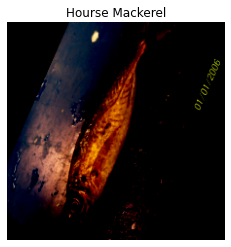

In [19]:
img, label = dataset[1]
plt.imshow(img.numpy().transpose((1, 2, 0)))
plt.title(classes[int(label)])
plt.axis('off')
plt.show()

## Split data into train test

In [20]:
batch_size = 20
train_set, test_set = torch.utils.data.random_split(dataset, [8000,1000])
train_loader = DataLoader(dataset=train_set,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(dataset=test_set,batch_size=batch_size,shuffle=True)

In [21]:
a = next(iter(train_loader))
a[0].size()

torch.Size([20, 3, 224, 224])

## Create ResNet18 based model

In [22]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 9.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 9)

In [25]:
torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

input_dim = dataset[0][0].shape[0] # Number of channels in the image (3)
output_dim = len(classes) # Number of classes (9)

loss_nn = nn.CrossEntropyLoss()
learning_rate = 1e-6
optimizer_nn = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [26]:
from torch.autograd import Variable
epochs = 10
iterations = 0
loss_list = []
iteration_list = []
accuracy_list = []

for epoch in range(epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        train = Variable(images.view(batch_size, 3, 224, 224))
        labels = Variable(labels)
        
        outputs = model(train)
        loss = loss_nn(outputs, labels)
        
        predictions = torch.max(outputs, 1)[1].to(device)
    
        optimizer_nn.zero_grad()
        
        loss.backward()
        
        optimizer_nn.step()
        
        iterations += 1
        
        if iterations % 50 == 0:
            corrects = 0
            total = 0
            
            for images, labels in test_loader:

                images, labels = images.to(device), labels.to(device)

                test = Variable(images.view(batch_size, 3, 224, 224))

                outputs = model(test)

                predict = torch.max(outputs.data, 1)[1].to(device)

                total += len(labels)

                corrects += (predict == labels).sum()
        
            acuracy = 100 * corrects / float(total)

            loss_list.append(loss.data)
            iteration_list.append(iterations)

    print(f"Epoch: {epoch+1} | Loss: {loss.data} | Acuracy: {acuracy}")
    

Epoch: 1 | Loss: 1.8161941766738892 | Acuracy: 40.500003814697266
Epoch: 2 | Loss: 1.1998218297958374 | Acuracy: 71.70000457763672
Epoch: 3 | Loss: 0.9519068598747253 | Acuracy: 88.30000305175781
Epoch: 4 | Loss: 0.633918285369873 | Acuracy: 94.4000015258789
Epoch: 5 | Loss: 0.6547180414199829 | Acuracy: 96.20000457763672
Epoch: 6 | Loss: 0.401864230632782 | Acuracy: 97.70000457763672
Epoch: 7 | Loss: 0.2461666315793991 | Acuracy: 98.30000305175781
Epoch: 8 | Loss: 0.15536217391490936 | Acuracy: 98.80000305175781
Epoch: 9 | Loss: 0.12237892299890518 | Acuracy: 98.4000015258789
Epoch: 10 | Loss: 0.1413262039422989 | Acuracy: 99.4000015258789


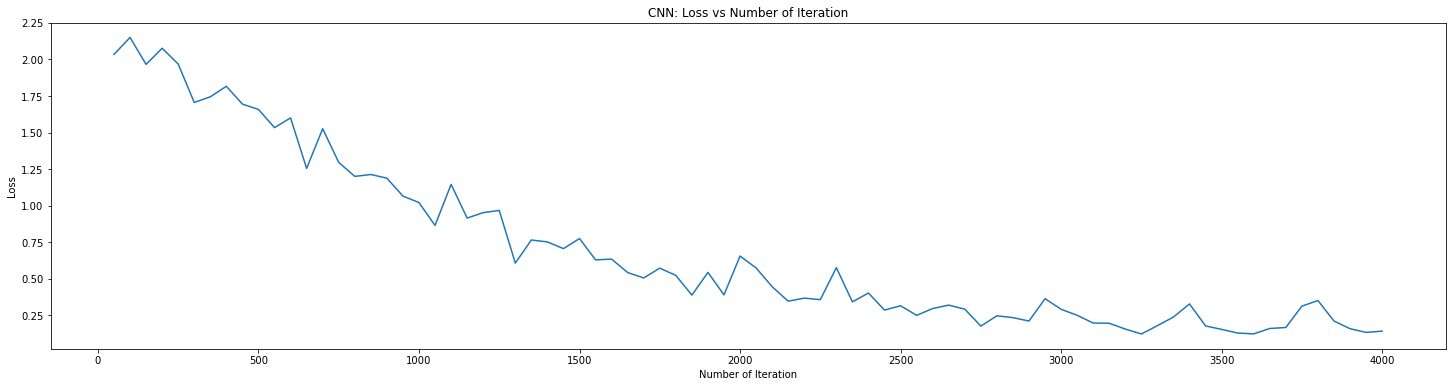

In [27]:
plt.figure(figsize=(25,6))
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of Iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of Iteration")
plt.show()